In [1]:
from common_preamble import *

Loading data from /Users/caseys/Work/data_analysis/ais_analysis_pipeline/data/in/data_v185_ais_bounds_v3_is_chandelier_v5.h5


Minimum AIS length: 37187.05055806807
	Computing aggregate AIS information


#### ChC AIS-targeting fraction

In [2]:
syn_in_analysis_set = np.isin(ais_synapse_data['post_pt_root_id'], list(ais_id_to_analyze))
ais_synapse_data = ais_synapse_data[syn_in_analysis_set]

in_analysis_set = np.isin(aggregated_ais_syn_df['post_pt_root_id'], list(ais_id_to_analyze))
aggregated_ais_syn_df = aggregated_ais_syn_df[in_analysis_set]

core_df = dl.query_cell_ids('manual_ais')
omit_targets = np.unique(core_df['pt_root_id'].values)

#pre_ais_ids = np.unique(ais_synapse_data[ais_synapse_data['is_chandelier']==True]['pre_pt_root_id'])
pre_ais_ids = np.unique(ais_synapse_data['pre_pt_root_id'])
targ_ids = np.unique(ais_synapse_data['post_pt_root_id'])
targ_ids_filt = targ_ids[~np.isin(targ_ids, omit_targets)]

In [3]:
all_syns = dl.query_synapses(synapse_table, pre_ids=pre_ais_ids, post_ids=targ_ids, import_via_buffer=False)
all_syns_core = dl.query_synapses(synapse_table, pre_ids=pre_ais_ids, post_ids=omit_targets, import_via_buffer=False)

In [4]:
import copy
ais_synapse_copy = copy.copy(ais_synapse_data)
ais_synapse_copy['is_ais'] = True
all_syn_label = all_syns.merge( ais_synapse_copy[['id', 'is_ais']], on='id', how='left').fillna(False)
all_syn_label = all_syn_label[['pre_pt_root_id', 'is_ais', 'id']].groupby(['pre_pt_root_id', 'is_ais']).count().reset_index()
all_syn_label = all_syn_label.pivot(index='pre_pt_root_id', columns='is_ais', values='id').fillna(0)
all_syn_label['All'] = np.sum(all_syn_label, axis=1)
all_syn_label = all_syn_label.reset_index()
all_syn_label = all_syn_label.merge(ais_synapse_copy[['pre_pt_root_id', 'is_chandelier']].drop_duplicates(), how='left', on='pre_pt_root_id')
all_syn_label['FractionAIS'] = all_syn_label[True] / all_syn_label['All']

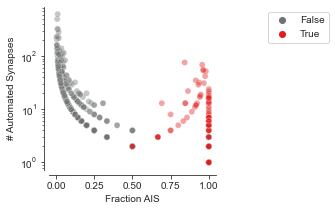

In [5]:
fig, ax = plt.subplots(figsize=(3,3), facecolor='w')
sns.scatterplot(y='All', x='FractionAIS', hue='is_chandelier', data=all_syn_label, palette=[non_color, chc_color], alpha=0.4, ax=ax)
ax.set_yscale('log')
ax.set_ylabel('# Automated Synapses')
ax.set_xlabel('Fraction AIS')
ax.legend(bbox_to_anchor=(1.7, 1))
sns.despine(ax=ax, offset=5)
# fig.savefig(f'{plot_dir}/specificity.pdf', bbox_inches='tight')

---

In [6]:
soma_df = dl.query_cell_types(soma_table)

In [7]:
def donut_plot(dist, ax=None, inner_radius=0.7, outer_radius=1, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.pie(dist, radius=outer_radius, **kwargs)
    circ=plt.Circle( (0,0), inner_radius, color='white')
    ax.add_artist(circ)

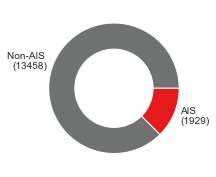

In [8]:
fig, ax = plt.subplots(figsize=(3,3), facecolor='w')
donut_plot( (sum(all_syn_label[False]), sum(all_syn_label[True])),
           inner_radius=0.6, ax=ax, colors=(non_color, chc_color),
           labels=['Non-AIS \n({})'.format(int(sum(all_syn_label[False]))),
                   'AIS\n({})'.format(int(sum(all_syn_label[True])))])
# fig.savefig(plot_dir + '/chc_ais_targeting_total.pdf',  bbox_inches="tight")

---
#### AIS-based plots

In [9]:
col_to_describe = ['num_cells', 'syn_net', 'syn_mean', 'syn_median', 'syn_max']
suffix = ['_chc', '_non']
from itertools import product
cols_to_show = [c+s for c,s in product(col_to_describe, suffix)]
ais_data_described_df = aggregated_ais_syn_df[cols_to_show].describe(percentiles=[]).unstack().unstack(1)
ais_data_described_df.to_csv(plot_dir + '/ais_data_summary_v{}.csv'.format(data_version))

In [ ]:
figsize=(2,2)
col_to_plot = ['num_cells', 'syn_net', 'syn_mean', 'syn_median', 'syn_max']
xlabels = ['# Cells', '# Synapses', 'Mean Synapse/Connection', 'Median Synapse/Connection', 'Max Synapse/Connection']
for col, xlab in zip(col_to_plot, xlabels):
    fc, ac, fn, an = plot_data_pair(aggregated_ais_syn_df, col, chc_color, non_color, figsize=figsize, xlabel=xlab,
                                    axis_label_font=axis_label_font, axis_tick_font=axis_tick_font)
    
    fc.savefig(plot_dir + '/{}_chc.pdf'.format(col),  bbox_inches="tight")
    fn.savefig(plot_dir + '/{}_non.pdf'.format(col),  bbox_inches="tight")

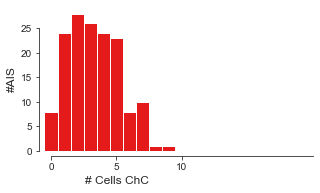

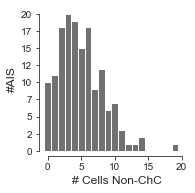

In [76]:
figsize=(2,2)
col_to_plot = ['num_cells']
xlabels = ['# Cells', '# Synapses', 'Mean Synapse/Connection', 'Median Synapse/Connection', 'Max Synapse/Connection']

for col, xlab in zip(col_to_plot, xlabels):
    fc, ac, fn, an = plot_data_pair(aggregated_ais_syn_df, col, chc_color, non_color, figsize=figsize, xlabel=xlab,
                                    axis_label_font=axis_label_font, axis_tick_font=axis_tick_font)
    ac.set_xlim(-0.5,10.5)
    fc.savefig(plot_dir + '/{}_chc.pdf'.format(col),  bbox_inches="tight")
    fn.savefig(plot_dir + '/{}_non.pdf'.format(col),  bbox_inches="tight")

In [81]:
aggregated_ais_syn_df['syn_max_chc'].describe()

count    153.000000
mean       3.222222
std        1.967573
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        9.000000
Name: syn_max_chc, dtype: float64

In [84]:
sum(aggregated_ais_syn_df['syn_max_chc'] > 2)

88

In [49]:
aggregated_ais_syn_df.columns

Index(['index', 'post_pt_root_id', 'pre_pt_root_id_chc', 'size_chc',
       'syns_chc', 'size_flat_chc', 'num_cells_chc', 'syn_net_chc',
       'syn_mean_chc', 'syn_median_chc', 'syn_var_chc', 'syn_max_chc',
       'size_net_chc', 'size_mean_chc', 'size_median_chc', 'size_var_chc',
       'size_max_chc', 'pre_pt_root_id_non', 'size_non', 'syns_non',
       'size_flat_non', 'num_cells_non', 'syn_net_non', 'syn_mean_non',
       'syn_median_non', 'syn_var_non', 'syn_max_non', 'size_net_non',
       'size_mean_non', 'size_median_non', 'size_var_non', 'size_max_non',
       'ais_len', 'n_syn_soma'],
      dtype='object')

In [52]:
y, bins = np.histogram(aggregated_ais_syn_df['syn_net_chc'], bins=np.arange(0,25))

122

In [64]:
np.std(aggregated_ais_syn_df['syn_net_chc'])

5.319530710525251

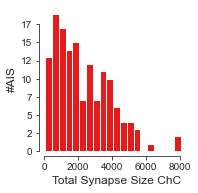

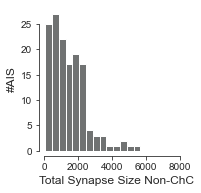

In [11]:
col_to_plot = ['size_net']
xlabels = ['Total Synapse Size']
for col, xlab in zip(col_to_plot, xlabels):
    fc, ac, fn, an = plot_data_pair(aggregated_ais_syn_df, col, chc_color, non_color, bin_increment=400, bin_start=50, xmax_extra=500,
                                    xlabel=xlab, figsize=figsize, axis_label_font=axis_label_font, axis_tick_font=axis_tick_font)

    fc.savefig(plot_dir + '/{}_chc.pdf'.format(col), bbox_inches="tight")
    fn.savefig(plot_dir + '/{}_non.pdf'.format(col), bbox_inches="tight")

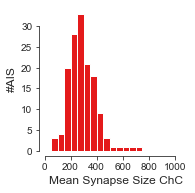

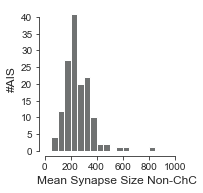

In [12]:
col_to_plot = ['size_mean']
xlabels = ['Mean Synapse Size']
for col, xlab in zip(col_to_plot, xlabels):
    fc, ac, fn, an = plot_data_pair(aggregated_ais_syn_df, col, chc_color, non_color, bin_increment=50, bin_start=50,
                                    xlabel=xlab, figsize=figsize, axis_label_font=axis_label_font, axis_tick_font=axis_tick_font)
    fc.savefig(plot_dir + '/{}_chc.pdf'.format(col), bbox_inches="tight")
    fn.savefig(plot_dir + '/{}_non.pdf'.format(col), bbox_inches="tight")

In [13]:
# from jitterbar import jitterbar

# col_to_plot = 'size_mean'

# fig, ax = plt.subplots(figsize=(2,4))
# suffix = ['_chc', '_non']
# data = [aggregated_ais_syn_df[col_to_plot+s][aggregated_ais_syn_df[col_to_plot+s]>0] for s in suffix]
# clrs = [chc_color, non_color]
# jitterbar(data, clrs, ax=ax, scatter_kwargs={'alpha':0.4, 's':20}, labels=['ChC', 'Non-ChC'], width=0.4, gap=0.3)
# ax.set_ylim((0,1200))
# ax.set_yticks(np.arange(0,1201,200))
# ax.set_ylabel('Mean synapse size (AU)')
# sns.despine(offset=2, ax=ax, trim=True)
# fig.savefig(plot_dir + '/jitter_bar_{}.pdf'.format(col_to_plot), bbox_inches="tight")
# from scipy import stats
# stats.ttest_ind(data[0], data[1])


---
#### Per Connection Plots

In [14]:
ais_synapse_data.head()

,index,id,pre_pt_position,pre_pt_root_id,ctr_pt_position,post_pt_position,post_pt_root_id,size,n_syn_soma,post_pt_mesh_ind,...,d_first,d_previous,d_previous_same_cell,d_closest,d_closest_diff_cell,d_top_skel,ais_len,orientation,syn_per_edge,is_chandelier
0,0,1763448,"[96680, 53768, 1397]",648518346346300466,"[96712, 53735, 1395]","[96658, 53764, 1399]",648518346349519354,129,105,620974,...,2873.253754,1256.013107,0.000000,1256.013107,1256.013107,13750.678761,67622.893572,2.504455,2,True
1,1,2357129,"[96736, 53958, 1430]",648518346346300466,"[96754, 53986, 1428]","[96740, 54056, 1430]",648518346349519354,524,105,622178,...,5515.567139,3690.869736,3690.869736,2749.297836,2749.297836,15282.422237,67622.893572,0.057104,2,True
2,2,2929296,"[96530, 53440, 1414]",648518346349538682,"[96557, 53475, 1413]","[96556, 53510, 1415]",648518346349519354,184,105,615634,...,0.000000,0.000000,0.000000,2506.224674,2506.224674,12576.412357,67622.893572,-2.560833,1,True
3,3,3071057,"[96732, 53638, 1400]",648518346349463803,"[96760, 53691, 1399]","[96674, 53716, 1400]",648518346349519354,558,105,621885,...,2506.224674,2506.224674,0.000000,1256.013107,1256.013107,13628.513577,67622.893572,2.046445,1,True
4,4,3227471,"[96862, 54296, 1443]",648518346349538677,"[96864, 54279, 1440]","[96812, 54280, 1441]",648518346349519354,280,105,624713,...,8264.864975,2749.297836,0.000000,2749.297836,2749.297836,16416.358627,67622.893572,0.647473,1,True


In [15]:
# ais_synapse_data_f = ais_synapse_data[ais_synapse_filter]
ais_synapse_data_f = ais_synapse_data

In [16]:
edge_list = ais_synapse_data_f[['pre_pt_root_id', 'post_pt_root_id', 'syn_per_edge', 'is_chandelier']].groupby(['pre_pt_root_id', 'post_pt_root_id']).mean().reset_index()
edge_syn_chc = edge_list[edge_list['is_chandelier']==True]['syn_per_edge'].values
edge_syn_non = edge_list[edge_list['is_chandelier']==False]['syn_per_edge'].values

In [17]:
output_count_df = ais_synapse_data_f.query('is_chandelier').groupby('pre_pt_root_id').count().reset_index()[['pre_pt_root_id', 'id']].rename(columns={'id':'num_output'})

In [18]:
edge_list_plus = edge_list.merge(output_count_df, left_on='pre_pt_root_id', right_on='pre_pt_root_id', how='left')

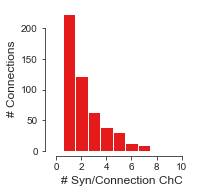

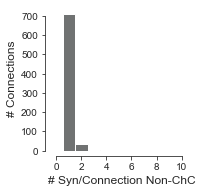

In [19]:
edge_syn_dict = {'edge_syn_chc':edge_syn_chc, 'edge_syn_non':edge_syn_non}
xlab = '# Syn/Connection'
fc, ac, fn, an = plot_data_pair(edge_syn_dict, 'edge_syn', chc_color, non_color, figsize=figsize, xlabel=xlab,
                                axis_label_font=axis_label_font, axis_tick_font=axis_tick_font, ylabel='# Connections')

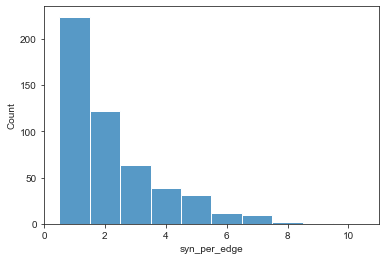

In [20]:
sns.histplot(edge_list_plus.query('is_chandelier and num_output > 0')['syn_per_edge'], bins=np.arange(0.5,11))

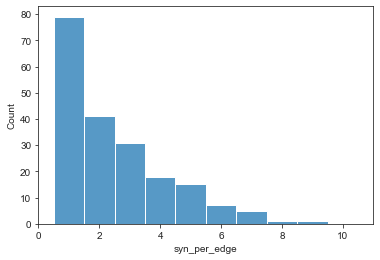

In [21]:
sns.histplot(edge_list_plus.query('is_chandelier and num_output > 20')['syn_per_edge'], bins=np.arange(0.5,11))

In [22]:
edge_list_chc = edge_list[edge_list['is_chandelier']==True]
edge_list_non = edge_list[edge_list['is_chandelier']==False]

edge_desc_chc = edge_list_chc['syn_per_edge'].describe()
edge_desc_non = edge_list_non['syn_per_edge'].describe()

edge_desc_df = pd.DataFrame([edge_desc_chc.rename('syn_per_connection_chc'),
                             edge_desc_non.rename('syn_per_connection_non')])

edge_desc_df.to_csv(plot_dir + '/syn_per_connection_stats_v{}.csv'.format(data_version))

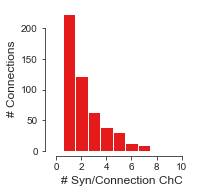

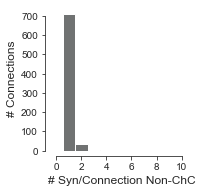

In [23]:
edge_syn_dict = {'edge_syn_chc':edge_syn_chc, 'edge_syn_non':edge_syn_non}
xlab = '# Syn/Connection'
fc, ac, fn, an = plot_data_pair(edge_syn_dict, 'edge_syn', chc_color, non_color, figsize=figsize, xlabel=xlab,
                                axis_label_font=axis_label_font, axis_tick_font=axis_tick_font, ylabel='# Connections')
fc.savefig(plot_dir + '/{}_chc.pdf'.format('edge_syn'), bbox_inches="tight")
fn.savefig(plot_dir + '/{}_non.pdf'.format('edge_syn'), bbox_inches="tight")

In [24]:
edge_syn_chc_plus20 = edge_list_plus.query('is_chandelier and num_output > 20')['syn_per_edge'].values

In [25]:
edge_syn_chc_plus20.shape

(198,)

0.44562334217506633


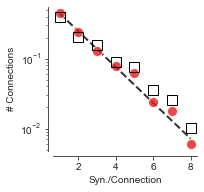

In [26]:
figsize=(2,2)

yct, ybin = np.histogram(edge_syn_chc, bins=np.arange(1,max(edge_syn_chc)+1))
yp_ct, ybin = np.histogram(edge_syn_chc_plus20, bins=np.arange(1,max(edge_syn_chc)+1))

fig, ax = plt.subplots(figsize=figsize)
fit_p = 1/np.mean(edge_syn_chc)
fit_ct = np.power((1-fit_p),ybin[:-1]-1) * fit_p
ax.plot(ybin[0:-1], fit_ct, 'k--', alpha=0.8, linewidth=2)
ax.plot(ybin[0:-1], yct/np.sum(yct), 'o', markersize=10, markeredgecolor='w', color=chc_color, alpha=0.8)
ax.plot(ybin[0:-1], yp_ct/np.sum(yp_ct), 's', markersize=10, markeredgecolor='k', markerfacecolor='none' )

ax.set_yscale('log')
sns.despine(ax=ax, offset=5)
set_axis_size(*figsize,ax)
ax.set_xlabel('Syn./Connection')
ax.set_ylabel('# Connections')
print(fit_p)
fig.savefig(plot_dir + '/connection_weight_distribution.pdf', bbox_inches="tight")
pd.DataFrame({'geometric_p': [fit_p]}).to_csv(plot_dir + '/connection_weight_geometric_fit.csv')

---

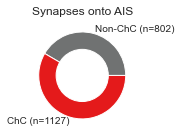

In [27]:
figsize=(2,2)

n_non_syns = np.sum(ais_synapse_data_f['is_chandelier']==False)
n_chc_syns = np.sum(ais_synapse_data_f['is_chandelier']==True)

fig, ax = plt.subplots(figsize=figsize)

ax.pie([n_non_syns, n_chc_syns], colors=[non_color, chc_color], labels=['Non-ChC (n={})'.format(n_non_syns), 'ChC (n={})'.format(n_chc_syns)])
ax.add_artist(plt.Circle( (0,0), 0.6, color='white'))
ax.set_title('Synapses onto AIS')
fig.savefig(plot_dir + '/num_syns_donut.pdf', bbox_inches='tight')

---
##### Per Synapse Plots

In [28]:
d_top_chc = ais_synapse_data[ais_synapse_data['is_chandelier']==True]['d_top_skel'] / 1000
d_top_non = ais_synapse_data[ais_synapse_data['is_chandelier']==False]['d_top_skel'] / 1000
d_top_non = d_top_non[~np.isinf(d_top_non)]
d_top_chc = d_top_chc[~np.isinf(d_top_chc)]
bins = np.arange(0, np.ceil(50), 2.5)

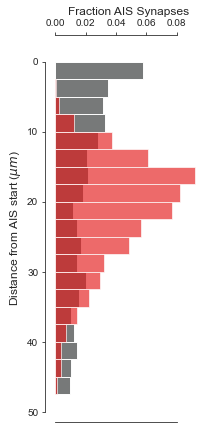

In [29]:
fig, ax = plt.subplots(figsize=(3,6))

d_top_non_hist, _ = np.histogram(d_top_non, bins=bins)
d_top_chc_hist, _ = np.histogram(d_top_chc, bins=bins)

ax.barh(bins[0:-1]+1.25, d_top_non_hist / (len(d_top_non)+len(d_top_chc)), color=non_color, alpha=0.95, edgecolor='w', height=2.5)
ax.barh(bins[0:-1]+1.25, d_top_chc_hist / (len(d_top_non)+len(d_top_chc)), color=chc_color, alpha=0.65, edgecolor='w', height=2.5)

ax.invert_yaxis()
ax.set_ylabel('Distance from AIS start ($\mu m$)')
ax.set_xlabel('Fraction AIS Synapses')
ax.xaxis.tick_top()
ax.set_yticks(np.arange(0,51,10))
ax.xaxis.set_label_position('top')
sns.despine(offset=10, trim=True, top=False, ax=ax)
set_axis_fonts(ax, axis_label_font, axis_tick_font, xprecision=2, yprecision=0)
fig.tight_layout()
fig.savefig(plot_dir + '/synapse_distance_along_ais.pdf', bbox_inches="tight")

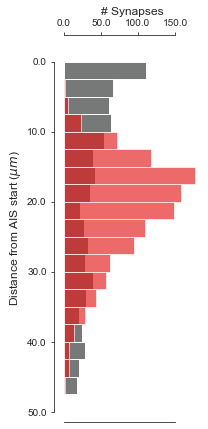

In [30]:
fig, ax = plt.subplots(figsize=(3,6))
sns.distplot(d_top_non, color=non_color, vertical=True, bins=bins,
                     ax=ax, kde=False, hist_kws={'alpha': 0.95, 'edgecolor':'w'})
sns.distplot(d_top_chc, color=chc_color, vertical=True, bins=bins,
                     ax=ax, kde=False, hist_kws={'alpha': 0.65, 'edgecolor':'w'})

ax.invert_yaxis()
ax.set_ylabel('Distance from AIS start ($\mu m$)')
ax.set_xlabel('# Synapses')
ax.xaxis.tick_top()
ax.set_yticks(np.arange(0,51,10))
ax.xaxis.set_label_position('top')
sns.despine(offset=10, trim=True, top=False, ax=ax)
set_axis_fonts(ax, axis_label_font, axis_tick_font)
fig.tight_layout()
fig.savefig(plot_dir + '/synapse_distance_along_ais.pdf', bbox_inches="tight")

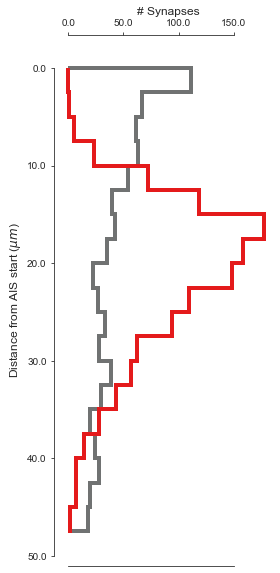

In [31]:
fig, ax = plt.subplots(figsize=(4,8))
sns.distplot(d_top_non, color=non_color, vertical=True, bins=bins,
                     ax=ax, kde=False, hist_kws={'alpha': 1, 'edgecolor':non_color, 'histtype':'step', 'linewidth':4},
                     norm_hist=False)
sns.distplot(d_top_chc, color=chc_color, vertical=True, bins=bins,
                     ax=ax, kde=False, hist_kws={'alpha': 1, 'edgecolor':chc_color, 'histtype':'step', 'linewidth':4},
                     norm_hist=False)

ax.invert_yaxis()
ax.set_ylabel('Distance from AIS start ($\mu m$)')
ax.set_xlabel('# Synapses')
ax.set_xlim((-4, ax.get_xlim()[1]))
ax.xaxis.tick_top()
ax.set_yticks(np.arange(0,51,10))
ax.xaxis.set_label_position('top')
sns.despine(offset=10, trim=True, top=False, ax=ax)
set_axis_fonts(ax, axis_label_font, axis_tick_font)
fig.tight_layout()
fig.savefig(plot_dir + '/synapse_distance_along_ais_lines.pdf', bbox_inches="tight")

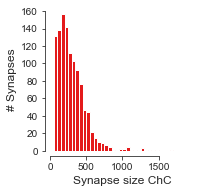

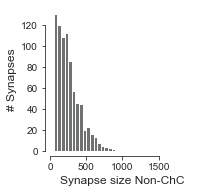

In [32]:
size_all_chc = ais_synapse_data_f[ais_synapse_data_f['is_chandelier']==True]['size']
size_all_non = ais_synapse_data_f[ais_synapse_data_f['is_chandelier']==False]['size']
size_all_dict = {'syn_size_chc': size_all_chc, 'syn_size_non': size_all_non}
xlab = 'Synapse size'
fc, ac, fn, an = plot_data_pair(size_all_dict, 'syn_size', chc_color, non_color, figsize=figsize, xlabel=xlab, bin_increment=50, bin_start=50,
                                axis_label_font=axis_label_font, axis_tick_font=axis_tick_font, ylabel='# Synapses')

fc.savefig(plot_dir + '/{}_chc.pdf'.format('syn_size'), bbox_inches="tight")
fn.savefig(plot_dir + '/{}_non.pdf'.format('syn_size'), bbox_inches="tight")

In [33]:
size_desc_chc = size_all_chc.describe()
size_desc_non = size_all_non.describe()

size_desc_df = pd.DataFrame([size_desc_chc.rename('synapse_size_chc'),
                             size_desc_non.rename('synapse_size_non')])

size_desc_df.to_csv(plot_dir + '/synapse_size_description_v{}.csv'.format(data_version))

---

In [34]:
n_multi_chc = np.sum(np.concatenate(aggregated_ais_syn_df['syns_chc'].apply(lambda x: np.array(x)[np.array(x)>1])))
n_multi_non = np.sum(np.concatenate(aggregated_ais_syn_df['syns_non'].apply(lambda x: np.array(x)[np.array(x)>1])))

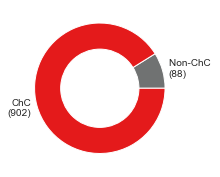

In [35]:
fig, ax = plt.subplots(figsize=(3,3))
donut_plot( (n_multi_non, n_multi_chc),
           inner_radius=0.6, ax=ax, colors=(non_color, chc_color),
           labels=['Non-ChC \n({})'.format(int(n_multi_non)),
                   'ChC\n({})'.format(int(n_multi_chc))])


In [36]:
min_th = [1, 2, 3, 4]
n_multi_chc = np.array([np.sum(np.concatenate(aggregated_ais_syn_df['syns_chc'].apply(lambda x: np.array(x)[np.array(x)>=mx]))) for mx in min_th])
n_multi_non = np.array([np.sum(np.concatenate(aggregated_ais_syn_df['syns_non'].apply(lambda x: np.array(x)[np.array(x)>=mx]))) for mx in min_th])

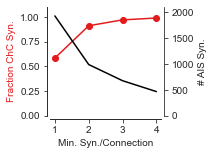

In [37]:
fig, ax = plt.subplots(figsize=(2,2))
ax.set_ylim(0,1.1)
ax.set_xticks(min_th)
ax.set_xlabel('Min. Syn./Connection')
ax.set_ylabel('Fraction ChC Syn.', color=chc_color)

ax2 = ax.twinx()  
ax2.plot(min_th, (n_multi_non+n_multi_chc), color='k', linestyle='-')
ax2.set_ylabel('# AIS Syn.')
ax2.set_ylim(0,2100)
ax.plot(min_th, n_multi_chc/(n_multi_non+n_multi_chc), color=chc_color, marker='o', linestyle='-')

sns.despine(offset=3, ax=ax2, right=False)
sns.despine(offset=3, ax=ax)

fig.savefig(plot_dir + '/fraction_from_chc_vs_non.pdf', bbox_inches="tight")

---

In [38]:
aggregated_ais_syn_df.columns

Index(['index', 'post_pt_root_id', 'pre_pt_root_id_chc', 'size_chc',
       'syns_chc', 'size_flat_chc', 'num_cells_chc', 'syn_net_chc',
       'syn_mean_chc', 'syn_median_chc', 'syn_var_chc', 'syn_max_chc',
       'size_net_chc', 'size_mean_chc', 'size_median_chc', 'size_var_chc',
       'size_max_chc', 'pre_pt_root_id_non', 'size_non', 'syns_non',
       'size_flat_non', 'num_cells_non', 'syn_net_non', 'syn_mean_non',
       'syn_median_non', 'syn_var_non', 'syn_max_non', 'size_net_non',
       'size_mean_non', 'size_median_non', 'size_var_non', 'size_max_non',
       'ais_len', 'n_syn_soma'],
      dtype='object')

In [39]:
ax.plot(aggregated_ais_syn_df['num_cells_chc'], aggregated_ais_syn_df['syn_mean_chc'], marker='o', color='k', markersize=1, alpha=0.5, linestyle='none')


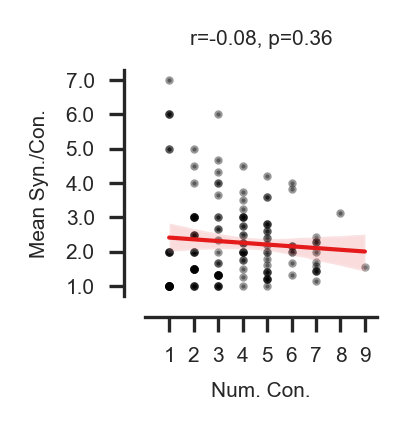

In [46]:
fig, ax = plt.subplots(figsize=(1, 1), dpi=300)
fg=sns.regplot(x='num_cells_chc', y='syn_mean_chc', data=aggregated_ais_syn_df, ax=ax, scatter_kws={'marker':'o', 'color':'k', 's':1, 'alpha':0.4},
               line_kws={'color': chc_color, 'linewidth':1})
ax.set_xticks(np.arange(1, 10))
ax.set_yticks(np.arange(1, 8))
sns.despine(ax=ax, offset=5)
ax.set_xlabel('Num. Con.')
ax.set_ylabel('Mean Syn./Con.')
set_axis_fonts(ax=ax, tick_font={'size':5}, label_font={'size':5}, xtick_int=True)
not_nan = ~np.isnan(aggregated_ais_syn_df['syn_mean_chc'])
ax.set_title(f"r={stats.pearsonr(aggregated_ais_syn_df['num_cells_chc'][not_nan], aggregated_ais_syn_df['syn_mean_chc'][not_nan])[0]:0.2f}, p={stats.pearsonr(aggregated_ais_syn_df['num_cells_chc'][not_nan], aggregated_ais_syn_df['syn_mean_chc'][not_nan])[1]:0.2f}", fontdict={'size':5})
ax.set_xlim(0, 9.5)
plt.savefig(f"{plot_dir}/syn_per_con_vs_num_con.pdf", bbox_inches='tight')

In [41]:
c, x = np.histogram(edge_syn_chc, np.arange(0.5,9.5))

In [ ]:
np.cumsum(c) / np.sum(c)

In [ ]:
(np.cumsum(c * np.arange(1,9)) / np.sum(c * np.arange(1,9)))

In [ ]:
fig, ax = plt.subplots(figsize=(0.75,0.75), dpi=150)
ax.plot([0, 9], [1,1], color=(0.7, 0.7, 0.7), linestyle='-', linewidth=0.75)
ax.plot(np.arange(1,9), (np.cumsum(c * np.arange(1,9)) / np.sum(c * np.arange(1,9))), 'o--', color=chc_color, markersize=3, linewidth=1)
ax.set_xticks(np.arange(1,9))
ax.set_yticks([0,0.5,1])
sns.despine(ax=ax, offset=1, trim=True)
ax.set_ylabel('Cum. Frac. ChC Syn.')
ax.set_xlabel('# ChC Syn. / Conn.')
set_axis_fonts(ax=ax, tick_font={'size':5}, xtick_int=True, label_font={'size':6})
fig.savefig(f'{plot_dir}/cumulative_synapses_by_connection_weight.pdf', bbox_inches='tight')